In [1]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import os
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import KFold

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation import test

from uncertain.explicit import Bias, MF, CPMF, OrdRec, BeMF
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import seaborn as sns

os.chdir('Movielens')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = ExplicitData(data, implicit=False, users_on_test=1000)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)

MovieLens data prepared: 6040 users, 3416 items.
871984 train, 93970 validation and 33657 test interactions.


# ExplicitMF (FunkSVD)

In [ ]:
for dim in [50, 100, 200]:
    for wd in [0.1, 0.01, 0.001]:
        model = MF(data.n_user, data.n_item, embedding_dim=dim, lr=0.00001, weight_decay=wd)
        train(model, data, path='checkpoints/baseline', name=f'dim={dim}-wd={wd}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test(model, data, name='Baseline', max_k=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


In [12]:
# Load baseline
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
baseline = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
baseline = baseline.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))

# Ensemble

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

'Success!'

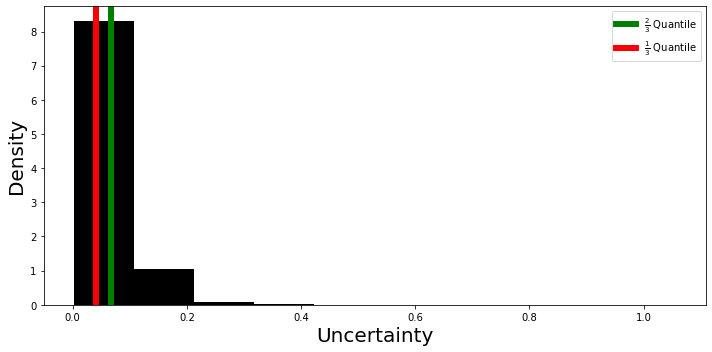

In [17]:
for i in range(4):
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=baseline.lr, weight_decay=baseline.weight_decay)
    train(model, data, path='checkpoints/ensemble', name=f'{i}')

models = [baseline]
for file in os.listdir('checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
test(ensemble, data, name='Ensemble', max_k=10)

# Resample

In [5]:
og = deepcopy(data.train)
for i in range(5):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=baseline.lr, weight_decay=baseline.weight_decay)
    train(model, data, path='checkpoints/resample', name=f'{i}')
data.train = og

# Resample
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(baseline, models)
test(resample, data, name='Resample', max_k=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

  0%|          | 0/6040 [00:00<?, ?it/s]

'Success!'

# Zhu et. al

In [6]:
errors = np.empty(len(data.train))
og = deepcopy(data.train)
og_val = deepcopy(data.val)
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=2, shuffle=True).split(data.train)):
    test_rat = og[test_idx]
    data.train = og[train_idx]
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=baseline.weight_decay)
    train(model, data, path='checkpoints/cv', name=f'cv{i}')
    errors[test_idx] = np.abs(model.predict(torch.tensor(test_rat[:, 0]).long(), torch.tensor(test_rat[:, 1]).long()) - test_rat[:, 2])
data.train = deepcopy(og)
data.train[:, 2] = errors
data.val[:, 2] = np.abs(model.predict(torch.tensor(data.val[:, 0]).long(), torch.tensor(data.val[:, 1]).long()) - data.val[:, 2])

# DoubleMF
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=baseline.weight_decay)
train(model, data, path='checkpoints/cv', name=f'MF')

# Bias
model = Bias(data.n_user, data.n_item, lr=0.0002)
train(model, data, path='checkpoints/cv', name=f'Bias')

#Fix
data.train = og
data.val = og_val

# Zhu
for file in os.listdir('checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('checkpoints/cv', file))
bias_cv = UncertainWrapper(baseline, bias)
test(bias_cv, data, name='CV-Bias', max_k=10)
mf_cv = UncertainWrapper(baseline, mf)
test(mf_cv, data, name='CV-PMF', max_k=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | user_bias | Embedding | 6.0 K 
1 | item_bias | Embedding | 3.4 K 
----------------------------------------
9.5 K     Trainable params
0         Non-trainable params
9.5 K     Total params
0.038     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

  0%|          | 0/6040 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

  0%|          | 0/6040 [00:00<?, ?it/s]

'Success!'

# CPMF

  0%|          | 0/1000 [00:00<?, ?it/s]

'Success!'

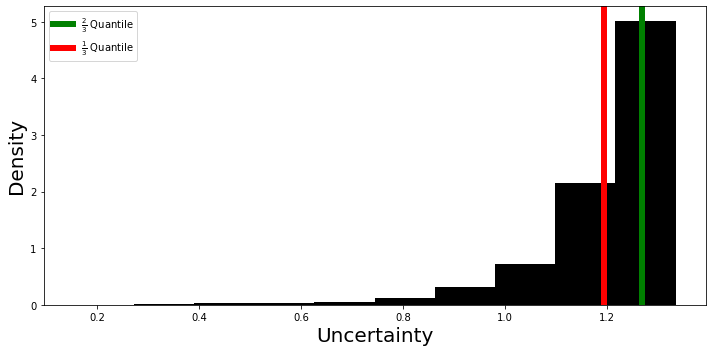

In [26]:
for lr in [0.00001, 0.000005, 0.000001]:
    model = CPMF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=lr, weight_decay=baseline.weight_decay, lr_var=lr)
    with torch.no_grad():
        model.user_embeddings.weight.copy_(baseline.user_embeddings.weight)
        model.item_embeddings.weight.copy_(baseline.item_embeddings.weight)
    train(model, data, path='checkpoints/cpmf', name=f'lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test(model, data, name='CPMF', max_k=10)

In [20]:
for lr in [0.00001, 0.000005]:
    model = CPMF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=lr, weight_decay=0, lr_var=lr)
    with torch.no_grad():
        model.user_embeddings.weight.copy_(baseline.user_embeddings.weight)
        model.item_embeddings.weight.copy_(baseline.item_embeddings.weight)

Parameter containing:
tensor([[ 0.0032, -0.0973,  0.2693,  ..., -0.1508, -0.0220, -0.1800],
        [ 0.0664, -0.0478,  0.1196,  ...,  0.0106,  0.0089, -0.1860],
        [ 0.1025,  0.0198,  0.1014,  ...,  0.0083,  0.0638, -0.1742],
        ...,
        [-0.1300,  0.0117,  0.1163,  ...,  0.1612,  0.0997, -0.1954],
        [ 0.2412,  0.0065,  0.0161,  ..., -0.0472, -0.0785, -0.2193],
        [ 0.1152, -0.0540,  0.1506,  ...,  0.0051, -0.0886, -0.1877]],
       requires_grad=True)

# OrdRec

  0%|          | 0/1000 [00:00<?, ?it/s]

'Success!'

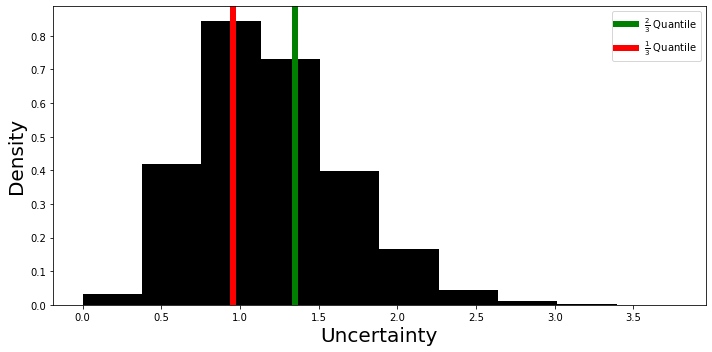

In [5]:
'''
data.to_ordinal()
for lr in [0.005, 0.001, 0.0005, 0.0001]:
    model = OrdRec(data.n_user, data.n_item, data.score_labels, embedding_dim=10, lr=0.0002, weight_decay=baseline.weight_decay, lr_step=lr)
    train(model, data, path='checkpoints/ordrec', name=f'lr={lr}')
'''
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/ordrec', min(files, key=files.get)))
test(model, data, name='OrdRec', max_k=10)

# BeMF

In [2]:
'''
data.to_ordinal()
for wd in [0.1, 0.01]:
    for lr in [0.01, 0.05]:
        model = BeMF(data.n_user, data.n_item, data.score_labels, embedding_dim=10, lr=lr, weight_decay=wd)
        train(model, data, path='checkpoints/bemf', name=f'wd={wd}-lr={lr}')
'''
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/bemf', min(files, key=files.get)))
test(model, data, name='BeMF', max_k=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

'Success!'

1/data.user.support# Results

In [2]:
# Baseline
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
baseline = MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
baseline = baseline.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test(baseline, data, name='Baseline', max_k=10)

# Heuristics
test(ItemHeuristic(base_MF=baseline, uncertainty=1/data.item.support.to_numpy()), data, name='Item_support', max_k=10)
test(ItemHeuristic(base_MF=baseline, uncertainty=data.item.variance.to_numpy()), data, name='Item_variance', max_k=10)

# Ensemble
models = [baseline]
for file in os.listdir('checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
test(ensemble, data, name='Ensemble', max_k=10)

# Resample
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(baseline, models)
test(resample, data, name='Resample', max_k=10)

# Zhu
for file in os.listdir('checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('checkpoints/cv', file))
bias_cv = UncertainWrapper(baseline, bias)
test(bias_cv, data, name='CV-Bias', max_k=10)
mf_cv = UncertainWrapper(baseline, mf)
test(mf_cv, data, name='CV-PMF', max_k=10)

# CPMF
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test(model, data, name='CPMF', max_k=10)

# OrdRec
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/ordrec', min(files, key=files.get)))
test(model, data, name='OrdRec', max_k=10)

# BeMF
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/bemf', min(files, key=files.get)))
test(model, data, name='BeMF', max_k=10)

Baseline - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

Item_support - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

Item_variance - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

Ensemble - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

CV-Bias - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

CV-PMF - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

CPMF - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

OrdRec - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

BeMF - Recommending:   0%|          | 0/1000 [00:00<?, ?it/s]

{'RMSE': 1.117432572715317,
 'RPI': 0.5862756665716246,
 'Classification': 0.6300289263005265,
 'Quantile RMSE': array([0.92242157, 0.9655381 , 0.989247  , 0.91887192, 0.94434924,
        1.        , 0.96214753, 1.00710489, 1.02378139, 1.04278279,
        1.04361227, 1.11703708, 1.13680918, 1.13524009, 1.20022788,
        1.23477056, 1.27943652, 1.24507348, 1.36938775, 1.56678515]),
 'Pearson error x unc': 0.18222062170006545,
 'Spearman error x unc': 0.1728987055988232,
 'dw': 0.6443635744609981,
 'User_unc_corr': {'support': -0.30849788737122547,
  'variance': 0.13567363776364563,
  'diversity': -0.11183361983914772},
 'Item_unc_corr': {'support': -0.7071307575755293,
  'variance': 0.334776644567574},
 'Pred_unc_corr': -0.2967651871792329,
 'Rating_rec': {'MAP': array([0.046     , 0.054     , 0.057     , 0.05972222, 0.06134722,
         0.06185444, 0.06241079, 0.06317389, 0.06382151, 0.06345048]),
  'Recall': array([0.00168039, 0.00208604, 0.00237014, 0.00311454, 0.00348211,
        

In [49]:
rated = data.train[data.train[:, 0] == 1, 1].astype(np.int)
targets = data.test[data.test[:, 0] == 1, 1].astype(np.int)

rated, targets

data.distances[targets][:, rated].min(1).mean(), data.distances[targets][:, np.random.randint(data.n_item, size=24)].min(1).mean()

(0.5660823380421949, 0.6518595535137534)

                   RMSE       RPI  Classification        dw  \
Baseline       0.871449       NaN             NaN       NaN   
BeMF           1.117433  0.586276        0.630029  0.644364   
CPMF           0.871358  0.087302        0.538532  0.196596   
CV-Bias        0.871449  0.728101        0.632386  0.565363   
CV-PMF         0.871449  0.689633        0.627789  0.477843   
Ensemble       0.871195  0.288006        0.538645  0.195783   
Item support   0.871449  0.700621        0.522091  0.121803   
Item variance  0.871449  0.399583        0.564779  0.266024   
OrdRec         0.885012  0.656954        0.643143  0.461979   
Resample       0.871449  0.436115        0.561125  0.277338   

               Pearson error x unc  Spearman error x unc  
Baseline                       NaN                   NaN  
BeMF                      0.182221              0.172899  
CPMF                      0.036868              0.058630  
CV-Bias                   0.227425              0.203512  
CV-PMF     

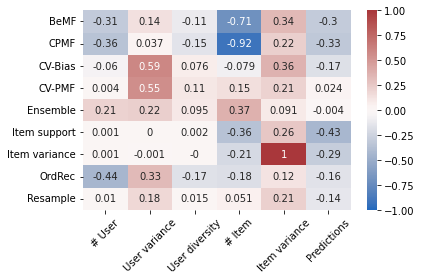

In [3]:
# Load
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
results = dict(sorted(results.items()))
colors = [c for c in list(TABLEAU_COLORS)] + ['k']
colors = {k:c for k, c in zip(results, colors)}

# Rating prediction evaluation
ratings = pd.DataFrame([results[key] for key in results], index=results.keys())[['RMSE', 'RPI', 'Classification', 'dw', 'Pearson error x unc', 'Spearman error x unc']]
print(ratings)

# Correlation plot
corr = np.empty((len(results)-1, 6))
keys = [key for key in results if key != 'Baseline']
for idx, key in enumerate(keys):
    corr[idx, :3] = np.fromiter(results[key]['User_unc_corr'].values(), dtype=np.float)
    corr[idx, 3:5] = np.fromiter(results[key]['Item_unc_corr'].values(), dtype=np.float)
    corr[idx, -1] = results[key]['Pred_unc_corr']
corr = pd.DataFrame(corr, index=keys, columns=['# User', 'User variance', 'User diversity', '# Item', 'Item variance', 'Predictions'])
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

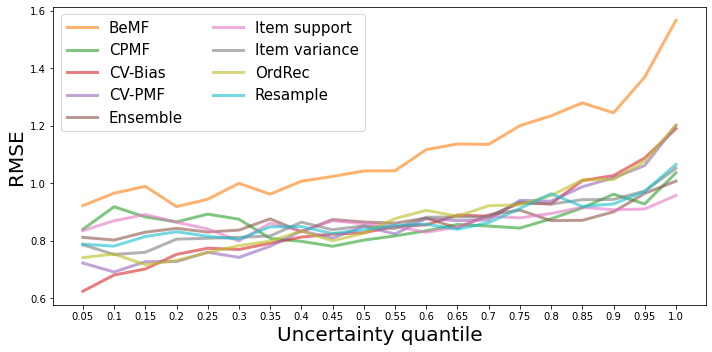

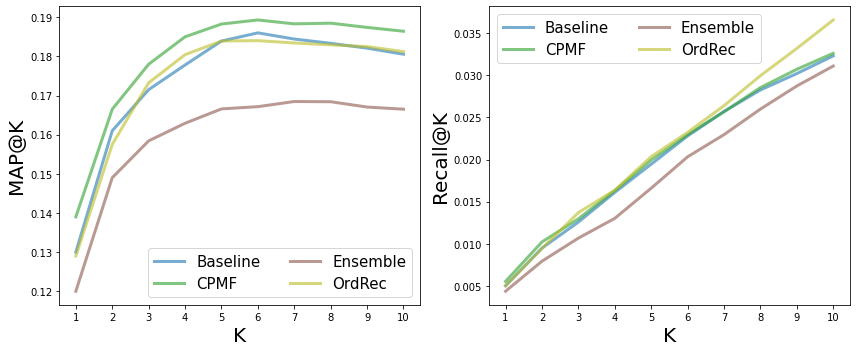

In [4]:
# Uncertainty-RMSE curve
keys = [key for key in results if key != 'Baseline']
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(np.arange(1, 21), results[key]['Quantile RMSE'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels([round(elem, 2) for elem in np.linspace(start=0.05, stop=1, num=20).tolist()])
ax.set_xlabel('Uncertainty quantile', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RMSE-uncertainty.pdf')

# Top-K accuracy metrics
keys = ['Baseline', 'CPMF', 'Ensemble', 'OrdRec']
f, ax = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results[key]['Rating_rec']['MAP'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results[key]['Rating_rec']['Recall'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('MAP@K', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Recall@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

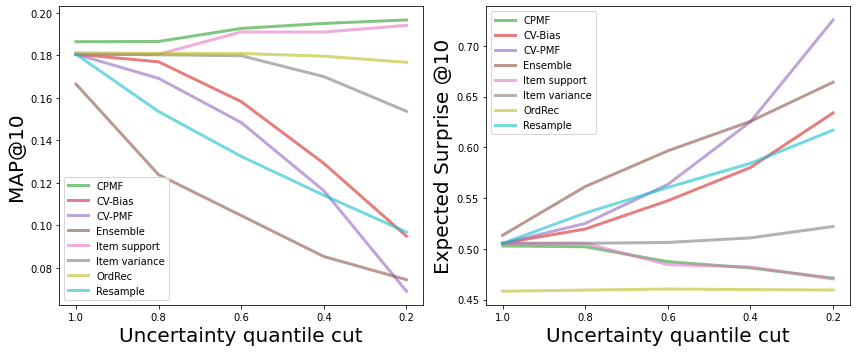

In [14]:
keys = [key for key in results if key != 'Baseline' and key != 'BeMF']
f, ax = plt.subplots(ncols=2, figsize=(12, 5))
for key in keys:
    ax[0].plot(results[key]['Cuts']['MAP'], '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(results[key]['Cuts']['Surprise'], '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(range(5))
ax[0].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[0].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[0].set_ylabel('MAP@10', fontsize=20)
ax[0].legend()
ax[1].set_xticks(range(5))
ax[1].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[1].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[1].set_ylabel('Expected Surprise @10', fontsize=20)
ax[1].legend()
f.tight_layout()
f.savefig('plots/cuts.pdf')

In [6]:
ratings = pd.DataFrame([results[key]['Rating_rec'] for key in keys], index=keys)[['URI_global', 'URI_rec', 'Unc_MAP_corr']]
print(ratings)

               URI_global   URI_rec  Unc_MAP_corr
CPMF             1.590417  0.424667      0.065656
CV-Bias          0.285047 -0.293998      0.053917
CV-PMF           0.184057 -0.272841      0.072536
Ensemble        -0.606558 -0.280958      0.253032
Item support     0.333129  0.338578     -0.034007
Item variance    0.843133 -0.251608      0.249722
OrdRec           1.350266  0.130946     -0.203164
Resample        -0.595756 -0.251557      0.162105


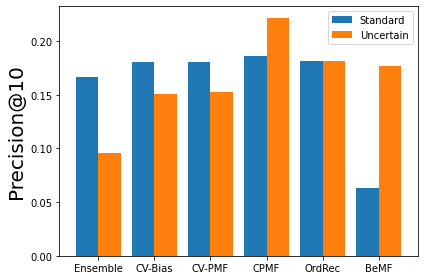

In [12]:
keys = ['Ensemble', 'CV-Bias', 'CV-PMF', 'CPMF', 'OrdRec', 'BeMF']
# Rating prediction evaluation
a = {metric: {key: [results[key]['Rating_rec'][metric][-1]] + [results[key]['Uncertain_rec'][metric][-1]] 
              for key in keys} for metric in ['MAP', 'Recall']}
precision = pd.DataFrame(a['MAP'], index=['Standard', 'Uncertain']).T
f, ax = plt.subplots()
ax.bar(np.arange(6)-0.2, precision['Standard'], 0.4, label='Standard')
ax.bar(np.arange(6)+0.2, precision['Uncertain'], 0.4, label='Uncertain')
ax.set_xticklabels([''] + list(precision.index))
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend()
f.tight_layout()
f.savefig('plots/unc_rank.pdf')

In [8]:
ratings = pd.DataFrame([results[key]['Uncertain_rec'] for key in keys], index=keys)[['URI_global', 'Unc_MAP_corr']]
print(ratings)

          URI_global  Unc_MAP_corr
Ensemble    1.640377      0.078398
CV-Bias     1.910263      0.037319
CV-PMF      1.915935      0.015016
CPMF        2.165245     -0.051484
OrdRec      1.427561     -0.109559
BeMF        1.727260     -0.334888
